In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torchvision.models as models
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import torch.nn.functional as F
import torch.multiprocessing as mp
import json

In [2]:
transform_all = T.Compose([
    T.Resize((224, 224)),   # paksa seragam
    T.ToTensor(),
])

In [3]:
data_root = "data"   # Ubah sesuai directory Anda
full_dataset = ImageFolder(data_root, transform=transform_all)
num_classes = len(full_dataset.classes)

# split dataset otomatis
train_size = int(0.7 * len(full_dataset))
val_size   = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [4]:
class ResNetBottleneck(nn.Module):
    def __init__(self, in_channels, filters):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, filters, 1)
        self.bn1 = nn.BatchNorm2d(filters)

        self.conv2 = nn.Conv2d(filters, filters, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(filters)

        self.conv3 = nn.Conv2d(filters, filters * 4, 1)
        self.bn3 = nn.BatchNorm2d(filters * 4)

        self.shortcut_needed = (in_channels != filters * 4)
        if self.shortcut_needed:
            self.shortcut_conv = nn.Conv2d(in_channels, filters * 4, 1)

    def forward(self, x):
        shortcut = x
        if self.shortcut_needed:
            shortcut = self.shortcut_conv(x)

        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))

        return torch.relu(x + shortcut)


class HybridEfficientNet(nn.Module):
    def __init__(self, num_classes=4, dropoout=0.3):
        super().__init__()

        # Load pretrained EfficientNet-B0
        self.base = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

        # Freeze feature extractor
        self.base.features.requires_grad_(False)

        #in_channels = 1280  # output EfficientNetB0 channels
        in_channels = self.base.features[-1].out_channels

        self.b1 = ResNetBottleneck(in_channels, 64)
        self.b2 = ResNetBottleneck(64 * 4, 64)

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(dropoout)
        self.fc = nn.Linear(64 * 4, num_classes)

    def forward(self, x):
        x = self.base.features(x)
        x = self.b1(x)
        x = self.b2(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x)

class HybridMobileNet(nn.Module):
    def __init__(self, num_classes=4, dropout=0.3):
        super().__init__()

        self.base = models.mobilenet_v3_small(
            weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1
        )

        self.base.features.requires_grad_(False)

        # ambil channel output terakhir
        in_channels = self.base.features[-1].out_channels  # = 576

        self.b1 = ResNetBottleneck(in_channels, 64)   # 576 → 256
        self.b2 = ResNetBottleneck(64 * 4, 64)        # 256 → 256

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(64 * 4, num_classes)      # 256 → num_classes

    def forward(self, x):
        x = self.base.features(x)
        x = self.b1(x)
        x = self.b2(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x)

In [5]:
def train_model(device, model, optimizer, name="model", scheduler=False, epochs=10):
    criterion = nn.CrossEntropyLoss()
    
    scheduler_optimizer = None
    if scheduler:
        scheduler_optimizer = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=epochs
        )
    
    start_time = time.perf_counter()

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accs.append(correct / total)

        model.eval()
        val_running_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)

                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = val_running_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_accs.append(correct / total)

        if scheduler_optimizer is not None:
            scheduler_optimizer.step() 

        print(f"[{name}] Epoch {epoch+1}/{epochs}")
        print(f"  Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        print(f"  Train Acc : {train_accs[-1]:.4f} | Val Acc : {val_accs[-1]:.4f}")

        clear_output(wait=True)

        fig, ax = plt.subplots(1, 2, figsize=(12, 5))

        # Loss panel
        ax[0].plot(train_losses, label="Train Loss")
        ax[0].plot(val_losses, label="Val Loss")
        ax[0].set_title("Training & Validation Loss")
        ax[0].legend()

        # Acc panel
        ax[1].plot(train_accs, label="Train Acc")
        ax[1].plot(val_accs, label="Val Acc")
        ax[1].set_title("Training & Validation Accuracy")
        ax[1].legend()

        plt.tight_layout()
        display(fig)
        plt.close(fig)

    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    return train_losses, val_losses, train_accs, val_accs, elapsed_time

def Summary(name, epoch, train_losses, val_losses, train_accs, val_accs, elapsed_time):
    print()
    print(f"[{name}]")
    print(f"  Total Epochs: {epoch}")
    print(f"  Train Loss: {np.average(train_losses):.4f} | Val Loss: {np.average(val_losses):.4f}")
    print(f"  Train Acc : {train_accs[-1]:.4f} | Val Acc : {val_accs[-1]:.4f}")
    print(f"  Time : {elapsed_time:.4f}s ~ {(elapsed_time / 60):.4f}m")

from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import torch

import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, class_names, figsize=(8,6)):
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest')
    plt.title("Confusion Matrix")
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Label angka di kotak
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "white")

    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

def classification_report_df(y_true, y_pred, class_names):
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    df = pd.DataFrame(report).transpose()
    return df

def evaluate_model(model, dataloader, device, class_names):
    start_time = time.perf_counter()
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    cm = confusion_matrix(all_labels, all_preds)

    return {
        "confusion_matrix": cm,
        "preds": all_preds,
        "labels": all_labels,
        "time": elapsed_time
    }

def clean_gpu():
    for var in list(globals().keys()):
        if isinstance(globals()[var], torch.Tensor):
            del globals()[var]

    import gc
    gc.collect()
    torch.cuda.synchronize()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

In [6]:
# Hyperparameter bounds
LR_MIN, LR_MAX = 1e-5, 5e-3
WD_MIN, WD_MAX = 1e-6, 1e-3
DP_MIN, DP_MAX = 0.1, 0.6

#global name, model
name = "mobresnet"
#model = HybridMobileNet(num_classes=4)

In [7]:
def evaluate_model_gpu(gpu_id, params, epochs=10):
    lr, wd, dropout = params

    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
    #device = torch.device("cuda")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    model = HybridMobileNet(num_classes=4)
    model.dropout.p = dropout
    model = model.to(device)

    optimizer = torch.optim.AdamW(
        model.parameters(), lr=lr, weight_decay=wd
    )

    # only 3 epoch for fitness evaluation
    train_losses, val_losses, train_accs, val_accs, _ = train_model(
        device, model, optimizer, name=name, scheduler=True, epochs=epochs
    )

    fitness = val_accs[-1]  # max acc = best
    #train_fitness = train_accs[-1]  # max acc = best

    torch.save(model.state_dict(), "./pso/" + name + "-" + str(fitness) + ".pth")

    del model
    del optimizer
    clean_gpu()

    return fitness

In [8]:
def save_row(result, filename):
    # Jadikan DataFrame 1 baris
    df = pd.DataFrame([result])

    # Jika file tidak ada → buat baru dengan header
    if not os.path.exists(filename):
        df.to_csv(filename, index=False)
    else:
        # Jika ada → append tanpa header
        df.to_csv(filename, mode="a", header=False, index=False)

    print(f"Row saved to {filename}")

In [9]:
import pyswarms.single as ps
import numpy as np

# parameter bounds
bounds = (np.array([LR_MIN, WD_MIN, DP_MIN]), np.array([LR_MAX, WD_MAX, DP_MAX]))

def pso_objective(X):
    results = []

    for i, params in enumerate(X):
        lr, wd, dp = params
        gpu_id = i % 2  # GPU 0 dan GPU 1 secara bergantian
        start_time = time.perf_counter()
        acc = evaluate_model_gpu(gpu_id, (lr, wd, dp), epochs=10)

        results.append(1 - acc)

        end_time = time.perf_counter()
        elapsed_time = end_time - start_time
        info = {
            "accuracy": float(acc),
            "learning_rate": float(lr),
            "weight_decay": float(wd),
            "dropout": float(dp),
            "time": elapsed_time
        }
        
        save_row(info, "pso_results.csv")
        
    return np.array(results)


def run_pso(n_particles=5, iters=3):
    optimizer = ps.GlobalBestPSO(
        n_particles=n_particles,
        dimensions=3,
        options={'c1': 1.5, 'c2': 2.0, 'w': 0.6},
        bounds=bounds
    )

    best_acc, best_param = optimizer.optimize(pso_objective, iters=iters)
    print(best_acc, best_param)
    val_acc = 1 - best_acc

    # Format data yang akan disimpan
    result = {
        "accuracy": float(val_acc),
        "best_parameters": {
            "learning_rate": float(best_param[0]),
            "weight_decay": float(best_param[1]),
            "dropout": float(best_param[2]),
        },
    }

    # Simpan ke file JSON
    save_path = "./" + name + "-pso.json"
    with open(save_path, "w") as f:
        json.dump(result, f, indent=4)

    print(f"[PSO] Hasil terbaik disimpan di {save_path}")

    return best_param, best_acc


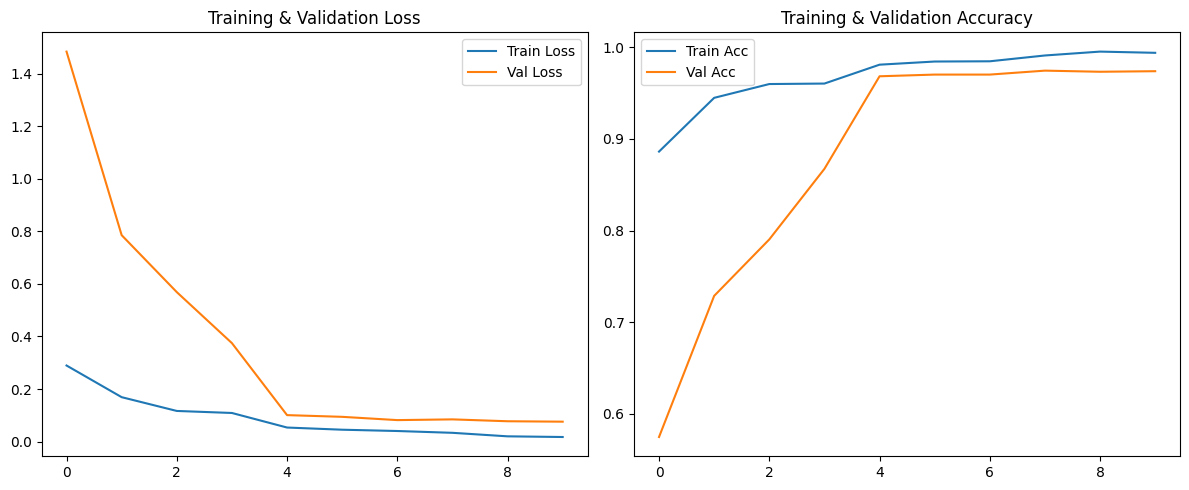

pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|10/10, best_cost=0.0173
2025-12-10 08:03:20,896 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.017273288093769268, best pos: [0.004174   0.00097433 0.21222921]


Row saved to pso_results.csv
0.017273288093769268 [0.004174   0.00097433 0.21222921]
[PSO] Hasil terbaik disimpan di ./mobresnet-pso.json
Best PSO: [0.004174   0.00097433 0.21222921] Acc: 0.017273288093769268


In [10]:
start_time = time.perf_counter()
best_pso, best_pso_acc = run_pso(n_particles=8, iters=10)
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print("Best PSO:", best_pso, "Acc:", best_pso_acc)